# EDA: Market Basket Analysis
- Ontology에 사전정의된 Slot(`meta_slot`)과 Dialogue 내 발화에 등장하는 단어 간 연관성을 분석
- Skill. 장바구니 분석(market basket analysis)

## Market Basket Analysis
- Association Rules라고 부르기도 함
- 다음의 3가지 지표를 활용
    1. 지지도(Support): (상품 A와 B가 동시에 포함된 사례 수) / (전체 사례 수), P(A∩B)
    2. 신뢰도(Confidence): (상품 A와 B가 동시에 포함된 사례 수) / (상품 A가 포함된 사례 수), P(A∩B) / P(A)
    3. 향상도(Lift): 상품 A가 없을 때 상품 B가 있을 확률과 상품 A가 있을 때 상품 B가 있을 확률의 비율, P(A∩B) / P(A)*P(B) = P (B|A) / P (B)
- 그렇다면, WoS 데이터셋에 어떻게 적용할 것인지 구체적으로 작성해보자.

### Market Basket Analysis for WoS
- level
    - '어떤 사람이 쇼핑을 하면서 구매한 상품 목록'은 구매 사례를 파악하는 단위가 '개인'임
    - 같은 맥락으로, WoS 데이터셋에는 어떤 단위가 좋을까?
    - 데이터를 살펴보니, turn 단위로 키워드 등장 빈도를 count하기에는, 추출되는 단어가 너무 적음
    - task-oriented dialogue는 기본적으로 하나의 대화가 하나의 주제를 가진다는 점에서, 빈도 count의 단위를 dialogue로 보는 것이 좋을 듯!

## WoS
- \# Meta Domain: Travel
- \# Domain: 5
- \# Slot: 45
- \# Avg Turn: 14.67
- \# Tokens per turn


In [3]:
import json
import sys
from tqdm import tqdm
from copy import deepcopy
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import konlpy
from konlpy.tag import Okt # Mecab은 윈도우 미지원
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
pd.set_option('display.max_rows', 500)
plt.style.use('ggplot')
# plt.rc('font', family='AppleSDGothicNeoSB00')
sys.path.insert(0, '../code/')

from utils import load_json

#### Load Data

In [8]:
SLOTMETA = '../input/data/train_dataset/slot_meta.json'
ONTOLOGY = '../input/data/train_dataset/ontology.json'
DIALS = '../input/data/train_dataset/train_dials.json'

In [9]:
ontology = load_json(ONTOLOGY)
slot_meta = load_json(SLOTMETA)
dials = load_json(DIALS)

#### Preprocessing for Market Basket Analysis

In [4]:
tagger = Okt()

In [5]:
NOUN = 'Noun'

def get_slot_meta(x):
    return '-'.join(x.split('-')[:-1])

def get_keywords(x, tagger: konlpy.tag):
    text_parsed = tagger.pos(x)
    parsed_filtered = filter(lambda x: x[-1] == NOUN and len(x[0]) > 1, text_parsed) # 명사 & 길이 2 이상
    keywords = list(map(lambda x: x[0], parsed_filtered))
    return keywords

total_items = [] # dialogue 단위로 단어 수집

for dial in tqdm(dials):
    dial_items = set()
    for turn in dial['dialogue']:
        if turn['role'] == 'sys':
            continue
        slot_items = set(map(get_slot_meta, turn['state']))
        keywords_items = set(get_keywords(turn['text'], tagger))
        turn_items = slot_items.union(keywords_items)
        dial_items = dial_items.union(turn_items)
    
    total_items.append(list(dial_items))

100%|██████████| 7000/7000 [03:02<00:00, 38.33it/s]


- 각 dialogue 별 수집 frequency 파악

In [6]:
frequency = pd.Series(list(map(len, total_items)))

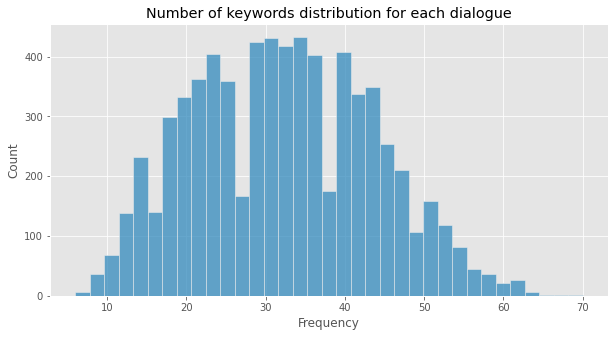

In [7]:
plt.figure(figsize=(10, 5))
sns.histplot(frequency)
plt.title('Number of keywords distribution for each dialogue')
plt.xlabel('Frequency')
plt.show()

In [8]:
frequency.describe()

count    7000.000000
mean       32.204286
std        11.460935
min         6.000000
25%        23.000000
50%        32.000000
75%        41.000000
max        70.000000
dtype: float64

- 쓸데 없는 단어 제거(stopword)

In [9]:
def flatten(x):
    output = []
    for value in x:
        if isinstance(x, list):
            output.extend(value)
        else:
            output.append(value)
    return output

In [10]:
total_items_flattend = flatten(total_items)

음 근데 생각보다 괜찮게 추출됐네. 이대로 가자

In [11]:
enc = TransactionEncoder()
transactions = enc.fit(total_items).transform(total_items, sparse=True)
transaction_table = pd.DataFrame.sparse.from_spmatrix(transactions, columns=enc.columns_)

In [12]:
transaction_table

,가가,가게,가격,가구,가기,가까이,가끔,가나,가능,가능성,...,후보,후움,휴가,휴식,휴일,흡연,흥미,흥인지문,힐링,힙니
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
apriori_table = apriori(transaction_table, min_support=0.25, use_colnames=True, verbose=1, low_memory=True)

Processing 13 combinations | Sampling itemset size 12


In [15]:
apriori_table.head(), apriori_table.shape

(    support itemsets
 0  0.606000     (가격)
 1  0.377714     (거기)
 2  0.510714  (관광-이름)
 3  0.444857  (관광-종류)
 4  0.445143  (관광-지역),
 (10777, 2))

In [16]:
association_table = association_rules(apriori_table, metric='confidence', min_threshold=0.5)

In [21]:
temp = association_table[association_table.sort_values(by='confidence', ascending=False).apply(lambda x: len(x['antecedents'])==1, axis=1)]

ipykernel_launcher:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


# Load from offline task

In [4]:
association_table = pd.read_csv('market_basket_analysis.csv')

In [5]:
# 저장한 데이터테이블을 불러오니 자료형이 제대로 매겨지지 않는 문제 발생
# 정규표현식으로 복구

def peel_antecedents(x):
    peeled = re.search(r"[가-힣]+-[가-힣]+|[가-힣]+", x).group(0)
    return peeled

def peel_consequents(x):
    peeled = re.findall(r"[가-힣]+-[가-힣]+|[가-힣]+|[가-힣]+-[가-힣]+ [가-힣]+", x)
    return peeled


In [6]:
association_table['antecedents'] = association_table['antecedents'].apply(lambda x: peel_antecedents(x))
association_table['consequents'] = association_table['consequents'].apply(lambda x: peel_consequents(x))
association_table.head(3)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,관광-이름,[가격],0.510714,0.606000,0.264286,0.517483,0.853932,-0.045207,0.816551
1,가격,[서울],0.606000,0.768429,0.508143,0.838520,1.091213,0.042475,1.434053
2,서울,[가격],0.768429,0.606000,0.508143,0.661275,1.091213,0.042475,1.163187


In [10]:
slot_association_table = association_table[association_table['antecedents'].isin(slot_meta)]
slot_association_table = slot_association_table[['antecedents', 'consequents', 'confidence']]
slot_association_table = slot_association_table.reset_index(drop=True)
slot_association_table.head(3)

,antecedents,consequents,confidence
0,관광-이름,[가격],0.517483
1,숙소-가격대,[가격],0.779213
2,숙소-이름,[가격],0.732964


In [11]:
slot_association_table_grouped = slot_association_table.groupby('antecedents').apply(lambda x: x.sort_values(by='confidence', ascending=False))
slot_association_table_grouped = slot_association_table_grouped.drop('antecedents', axis=1)
slot_association_table_grouped.index = slot_association_table_grouped.index.droplevel(level=1)
slot_association_table_grouped.head(10)

,consequents,confidence
antecedents,,
관광-이름,[관광-지역],0.831608
관광-이름,[관광-종류],0.831329
관광-이름,"[관광-종류, 관광-지역]",0.830769
관광-이름,[서울],0.772587
관광-이름,[예약],0.772028
관광-이름,"[서울, 관광-지역]",0.688671
관광-이름,"[관광-종류, 서울]",0.688112
관광-이름,"[관광-종류, 서울, 관광-지역]",0.688112
관광-이름,"[예약, 관광-지역]",0.642517


In [12]:
def sift_keywords(x):
    """consequents에 slot을 제외한 키워드만을 잔류"""
    output = [value for value in x if value not in slot_meta]
    return output

slot_association_table_grouped['consequents'] = slot_association_table_grouped['consequents'].apply(lambda x: sift_keywords(x))
slot_association_table_grouped = slot_association_table_grouped[slot_association_table_grouped['consequents'].apply(bool)]
slot_association_table_grouped.head(10)

,consequents,confidence
antecedents,,
관광-이름,[서울],0.772587
관광-이름,[예약],0.772028
관광-이름,[서울],0.688671
관광-이름,[서울],0.688112
관광-이름,[서울],0.688112
관광-이름,[예약],0.642517
관광-이름,[예약],0.642517
관광-이름,[예약],0.641958
관광-이름,"[서울, 예약]",0.613986


In [13]:
slot_association_table_grouped['consequents'] = slot_association_table_grouped['consequents'].apply(sorted)
slot_association_table_grouped = slot_association_table_grouped.reset_index()

In [14]:
slot_association_table_grouped.head()

,antecedents,consequents,confidence
0,관광-이름,[서울],0.772587
1,관광-이름,[예약],0.772028
2,관광-이름,[서울],0.688671
3,관광-이름,[서울],0.688112
4,관광-이름,[서울],0.688112


In [18]:
def flatten(x):
    output = []
    for value in x:
        if isinstance(value, list):
            output.extend(value)
        else:
            output.append(value)
    return output
            
def into_basket(x, classes):
    output = []
    for c in classes:
        if x[c] > 0:
            output.append(c)
    return output


def get_market_analysis_result(slot: str='관광-이름'):
    table_filtered = slot_association_table_grouped[slot_association_table_grouped['antecedents']==slot].reset_index(drop=True)

    # 메타 정보 수집
    classes = list(set(flatten(table_filtered['consequents'].tolist())))
    num_classes = len(classes)
    num_samples = len(table_filtered)

    # 중복 샘플 제거
    num_cols = num_classes + 2
    slot_onehot_frame = pd.DataFrame(np.zeros((num_samples, num_cols)), columns=['antecedents'] + classes + ['confidence'])
    slot_onehot_frame[['antecedents', 'confidence']] = table_filtered[['antecedents', 'confidence']]

    for idx, row in table_filtered.iterrows():
        for k in row['consequents']:
            slot_onehot_frame.loc[idx, k] += 1

    unique_indices = slot_onehot_frame.iloc[:, :-1].drop_duplicates().index.tolist()
    slot_onehot_frame = slot_onehot_frame.loc[unique_indices, :].reset_index(drop=True)

    # association rules table 형태로 재구성
    result = deepcopy(slot_onehot_frame[['antecedents', 'confidence']])
    result['consequents'] = slot_onehot_frame.apply(lambda x: into_basket(x, classes), axis=1)
    result = result[['antecedents', 'consequents', 'confidence']]

    return result
    

In [19]:
slot_list = slot_association_table_grouped['antecedents'].unique().tolist()

In [26]:
result_list = []

for s in slot_list:
    result_list.append(get_market_analysis_result(s))

In [36]:
temp = deepcopy(result_list[0])
temp['consequents'] = temp['consequents'].apply(str)